In [1]:
# Required imports
from collections import namedtuple
import numpy as np
import datetime
from netCDF4 import Dataset
import configparser
from matplotlib import pyplot as plt
from cftime import num2pydate
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands

# Creating initial position file

In [42]:
# setting the initial position for lake 
import os
data_dir = '/home/samin/data/FVCOME_OUTPUT'.format(os.environ['HOME'])
from pylag.processing.coordinate import get_epsg_code, utm_from_lonlat, lonlat_from_utm, british_national_grid_to_lonlat
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group
from pylag.processing.input import create_initial_positions_file_multi_group

# keep a copy of cwd
cwd = os.getcwd()
# create a run directory  
simulation_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/horon'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set 
group_id = 1
# Lat and lon coordiantes for the centre of the release zone

# Lake Huron west
#lat = 45.598943
#lon = 272
#lat = 42
#lon = -84.180371
#lat= 44.52993 
#lon = 271.98904

# Lake Huron Ausable Point
lat = 44.4821
lon = 276.87

# Convert to UTM coordinates
#epsg_code = '3174' #Projected coordinate system for Canada and United States
#epsg_code = '4326'
#epsg_code = '32630'
epsg_code = '4978'

#epsg_code = get_epsg_code(lon, lat)
easting, northing, _ = utm_from_lonlat([lon], [lat], epsg_code=epsg_code)

# Release zone radius (m)
radius = 0.1

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir =  '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions_Ausable.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

In [69]:
import os

from pylag.processing.coordinate import get_epsg_code, utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = f"{cwd}/home/samin/data/FVCOME_OUTPUT/simulations/horon"
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
#lat = 45.598943
#lon = 275.819629

# Convert to UTM coordinates
#easting, northing  = get_epsg_code(lon, lat)
#easting, northing, _ = utm_from_lonlat([lon], [lat], epsg_code=epsg_code)

# Release zone radius (m)
radius = 50.0

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [lat, lon],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir = f"{simulation_dir}/input"
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = f"{input_dir}/initial_positions2.dat"

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

# see the initial position of particles

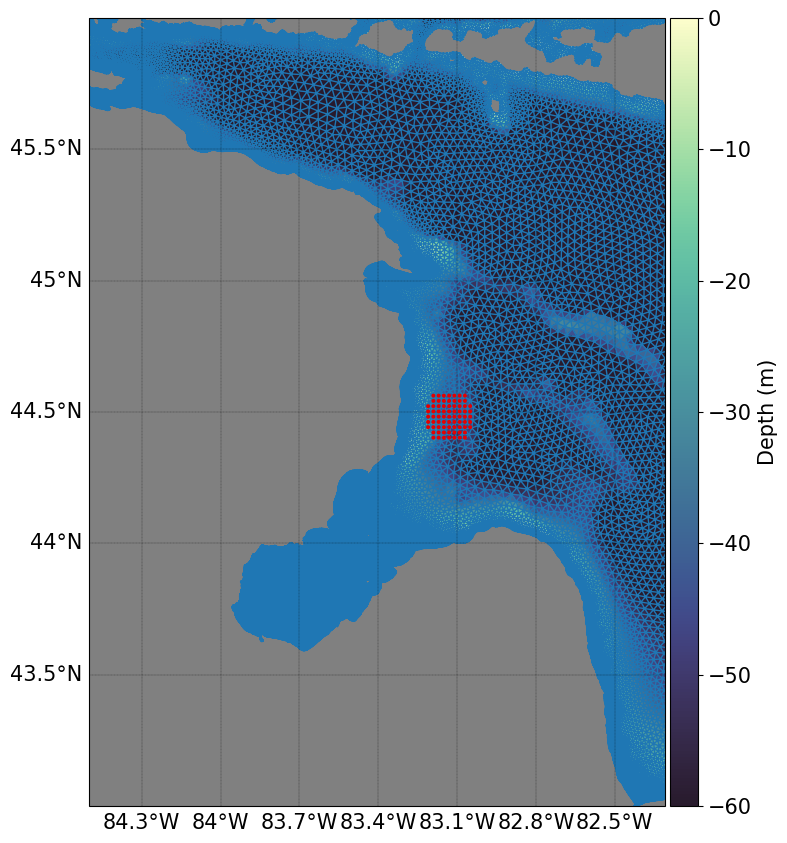

In [43]:
# Convert utm coords to degrees
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             epsg_code=epsg_code)

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(),
                       font_size=font_size, bg_color='gray')


#Grid metrics file name
grid_metrics_file_name = f"{input_dir}/grid_metrics_huron.nc"
# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-813, 43,46], dtype=float)
#Lake Huron Ausable Point
extents = np.array([275.5,277.69, 43,46], dtype=float)

ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')



# Creating FVCOME grid metrics file for lake Huron

In [7]:
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# An example FVCOM output file
fvcom_file_name = f'{data_dir}/fvcome_houron_estuary_0001.nc'

# The file listing the location of open boundary nodes
obc_file_name = f'{data_dir}/fvcom_tamar_estuary_obc.dat'

# The name of the output file
grid_metrics_file_name = f'{input_dir}/grid_metrics_huron.nc'

# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/samin/data/FVCOME_OUTPUT/simulations/horon/input/grid_metrics_huron.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - nbe variable not found in the FVCOM file. The nbe variable will be reconstructed from the nv variable.
Grid has 45 nodes on the open boundary


# Creating run configuration

In [81]:
import configparser
config_file_name = './FVCOME_OUTPUT/confings/fvcome_forward_template_houron.cfg'


cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates
print('Model name: {}'.format(cf.get('OCEAN_DATA', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_DATA', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_DATA', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_DATA', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2022-11-28 03:00:00
End time: 2022-11-28 18:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: geographic
Data directory: ./FVCOME_OUTPUT
Path to grid metrics file: /home/samin/data/FVCOME_OUTPUT/simulations/horon/input/grid_metrics_huron.nc
File name stem of input files: fvcome_houron_estuary_0001
Numerical method: standard
Iterative method: Adv_RK4_3D


In [82]:
cf.set('OCEAN_DATA', 'data_dir', data_dir)
cf.set('OCEAN_DATA', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open(f"{simulation_dir}/pylag.cfg", 'w') as config:
    cf.write(config)

In [83]:
# Change to the run directory
os.chdir(f"{simulation_dir}")

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)

Traceback (most recent call last):
  File "/root/miniconda3/envs/pylag/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/root/miniconda3/envs/pylag/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/root/miniconda3/envs/pylag/lib/python3.9/site-packages/pylag/main.py", line 82, in <module>
    main()
  File "/root/miniconda3/envs/pylag/lib/python3.9/site-packages/pylag/main.py", line 75, in main
    simulator.run()
  File "/root/miniconda3/envs/pylag/lib/python3.9/site-packages/pylag/simulator.py", line 106, in run
    self.initial_particle_state_reader.get_particle_data()
  File "/root/miniconda3/envs/pylag/lib/python3.9/site-packages/pylag/particle_initialisation.py", line 81, in get_particle_data
    x2_positions.append(self._get_entry(row[2], DTYPE_FLOAT))
  File "/root/miniconda3/envs/pylag/lib/python3.9/site-packages/pylag/particle_initialisation.py", line 92, in _get_entry
    return

FileNotFoundError: [Errno 2] No such file or directory: b'/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/pylag_1.nc'

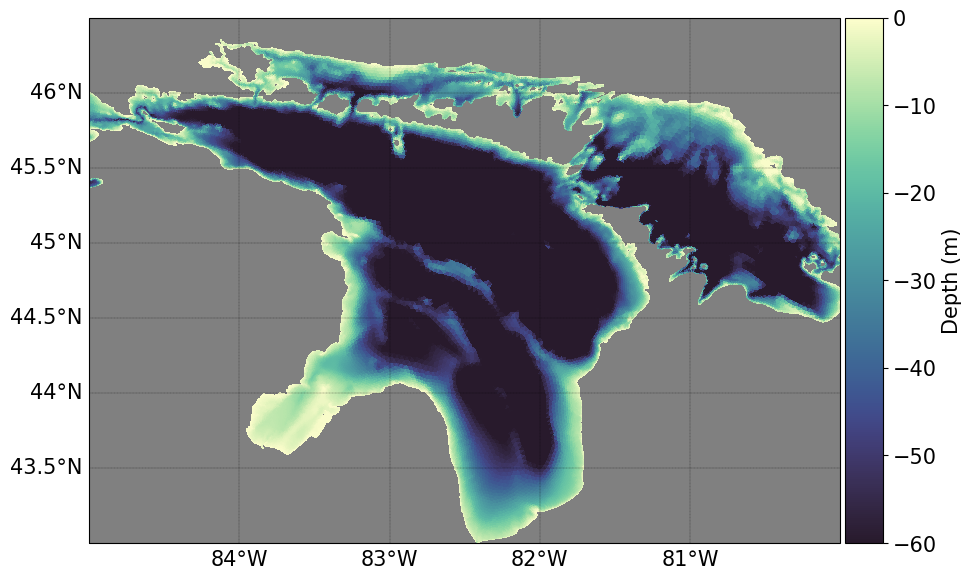

In [62]:
from datetime import timedelta

from pylag.processing.ncview import Viewer


file_name = '{}/output/pylag_1.nc'.format(simulation_dir)

# Time of flight
time_of_flight = timedelta(hours=15)

# Plot extents
extents = np.array([-85,-80, 43,46.5], dtype=float)

fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot the bathymetry again. We'll overlay pathlines on top of this.
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=900)

# Get time index
date = viewer.date[0] + time_of_flight
time_index = viewer.date.tolist().index(date)
n_times = viewer.date[:time_index+1].shape[0]

# Convert positions into lons/lats
lons, lats = lonlat_from_utm(viewer('x')[time_index, :].squeeze(),
                             viewer('y')[time_index, :].squeeze(), epsg_code=epsg_code)

# Plot particle final positions
ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

# Convert all pathline coordinates into lons/lats
for i in range(1,61):
    lons_paths, lats_paths = lonlat_from_utm(viewer('x')[:,i],viewer('y')[:,i], epsg_code='32630')

# Add path lines
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.18, alpha=1,color='#0504aa')